# Imports

In [166]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import utils

%matplotlib inline
%config InlineBackend.format_figure = 'retina'
pd.set_option('display.max_columns', 200)
sns.set()

In [2]:
%reload_ext autoreload
%autoreload 2

# Load Data

In [3]:
PATH = Path('data/raw/')
!ls {PATH}

submission_format.csv test_data.csv         training_data.csv


In [4]:
!head -1 {PATH / 'training_data.csv'}

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1


In [5]:
raw_df = pd.read_csv(PATH / 'training_data.csv', index_col=0)
raw_df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


# EDA

In [6]:
raw_df.get_dtype_counts()

float64     2
object     23
dtype: int64

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [8]:
(raw_df.isnull().sum() / raw_df.shape[0]).sort_values(ascending=False)

Text_4                    0.865728
Facility_or_Department    0.865378
Text_2                    0.779610
Sub_Object_Description    0.771151
Text_3                    0.727309
FTE                       0.685041
Location_Description      0.595145
Fund_Description          0.493158
Position_Extra            0.338548
Text_1                    0.269793
Job_Title_Description     0.268649
Program_Description       0.238877
SubFund_Description       0.233393
Function_Description      0.145105
Object_Description        0.061917
Total                     0.011380
Operating_Status          0.000000
Pre_K                     0.000000
Object_Type               0.000000
Position_Type             0.000000
Student_Type              0.000000
Reporting                 0.000000
Sharing                   0.000000
Use                       0.000000
Function                  0.000000
dtype: float64

In [9]:
raw_df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


In [10]:
raw_df.FTE.dropna().value_counts().sort_values(ascending=False)

1.000000    35788
0.000000    31338
0.004310     8130
0.002155     2735
0.008621     2293
0.025000     2020
0.500000     1825
0.012931      941
0.006466      712
0.017241      479
0.250000      398
0.750000      383
0.150000      366
0.200000      351
0.875000      341
0.010776      324
0.021552      308
0.940000      291
0.005435      279
0.710000      270
0.100000      269
0.880000      269
0.850000      263
0.030000      263
0.400000      249
0.001078      234
0.010000      229
0.730000      222
0.860000      216
0.025862      206
            ...  
0.416678        1
0.543728        1
0.966025        1
0.010648        1
0.500057        1
1.010761        1
0.702961        1
0.500015        1
0.500013        1
0.537728        1
0.638517        1
0.036714        1
0.020418        1
0.442115        1
0.283343        1
0.996707        1
0.916689        1
0.916690        1
0.995539        1
0.666684        1
0.666683        1
0.077382        1
0.919807        1
0.182920        1
0.022675  

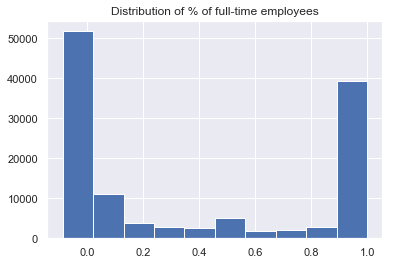

In [11]:
plt.hist(raw_df.FTE.dropna()[raw_df.FTE.dropna() <= 1])
plt.title('Distribution of % of full-time employees');

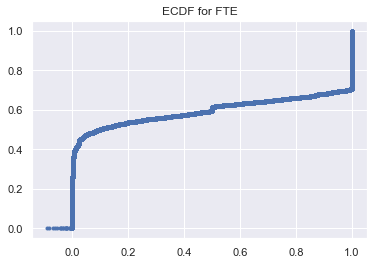

In [12]:
def get_ecd(arr):
    x = np.sort(arr)
    y = np.arange(len(arr)) / len(arr)
    return x, y

x, y = get_ecd(raw_df.FTE.dropna()[raw_df.FTE.dropna() <= 1])
plt.plot(x, y, marker='.', linestyle='none')
plt.title('ECDF for FTE');

In [13]:
(raw_df.FTE.dropna() < 0).sum(), (raw_df.FTE.dropna() > 1.05).sum()

(51, 195)

In [14]:
FEATURES = [
    'FTE', 'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4', 'Total'
]

NUMERICAL_FEATURES = [
    'FTE', 'Total'
]

TEXT_FEATURES = [
    'Facility_or_Department', 'Function_Description', 'Fund_Description',
    'Job_Title_Description', 'Location_Description', 'Object_Description',
    'Position_Extra', 'Program_Description', 'SubFund_Description',
    'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4',
]
LABELS = [
    'Function', 'Object_Type', 'Operating_Status', 'Position_Type',
    'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use'
]

In [15]:
# Make sure i did not miss any feature
len(NUMERICAL_FEATURES + TEXT_FEATURES + LABELS) == raw_df.shape[1]

True

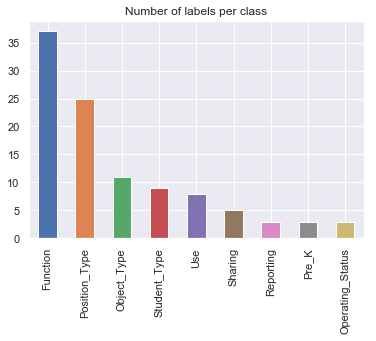

In [16]:
raw_df[LABELS].apply(pd.Series.nunique).sort_values(ascending=False).plot(kind='bar')
plt.title('Number of labels per class');

Notes:
- We have two numerical features and 23 of type `Object`.
- The two numerical features need standardization. Also, they have missing values so we need to use some kind of imputation.

# Data Preprocessing

In [17]:
# Convert labels into categorical variables
df = raw_df.copy()
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
df.get_dtype_counts()

category     9
float64      2
object      14
dtype: int64

In [18]:
# Example of catgories in one label
df.Operating_Status.cat.categories

Index(['Non-Operating', 'Operating, Not PreK-12', 'PreK-12 Operating'], dtype='object')

In [19]:
# Convert labels to dummy variables
df = pd.get_dummies(df, columns=LABELS, prefix_sep='__')
len(df.columns)

120

In [20]:
df.head()

,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,Function__Special Population Program Management & Support,Function__Student Assignment,Function__Student Transportation,Function__Substitute Compensation,Function__Teacher Compensation,Function__Untracked Budget Set-Aside,Function__Utilities,Object_Type__Base Salary/Compensation,Object_Type__Benefits,Object_Type__Contracted Services,Object_Type__Equipment & Equipment Lease,Object_Type__NO_LABEL,Object_Type__Other Compensation/Stipend,Object_Type__Other Non-Compensation,Object_Type__Rent/Utilities,Object_Type__Substitute Compensation,Object_Type__Supplies/Materials,Object_Type__Travel & Conferences,Operating_Status__Non-Operating,"Operating_Status__Operating, Not PreK-12",Operating_Status__PreK-12 Operating,Position_Type__(Exec) Director,Position_Type__Area Officers,Position_Type__Club Advisor/Coach,Position_Type__Coordinator/Manager,Position_Type__Custodian,Position_Type__Guidance Counselor,Position_Type__Instructional Coach,Position_Type__Librarian,Position_Type__NO_LABEL,Position_Type__Non-Position,Position_Type__Nurse,Position_Type__Nurse Aide,Position_Type__Occupational Therapist,Position_Type__Other,Position_Type__Physical Therapist,Position_Type__Principal,Position_Type__Psychologist,Position_Type__School Monitor/Security,Position_Type__Sec/Clerk/Other Admin,Position_Type__Social Worker,Position_Type__Speech Therapist,Position_Type__Substitute,Position_Type__TA,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
134338,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
206341,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
326408,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRA

In [60]:
new_labels = df.columns.difference(NUMERICAL_FEATURES + TEXT_FEATURES)
new_labels

Index(['Function__Aides Compensation',
       'Function__Career & Academic Counseling', 'Function__Communications',
       'Function__Curriculum Development',
       'Function__Data Processing & Information Services',
       'Function__Development & Fundraising', 'Function__Enrichment',
       'Function__Extended Time & Tutoring',
       'Function__Facilities & Maintenance', 'Function__Facilities Planning',
       ...
       'Student_Type__Special Education', 'Student_Type__Unspecified',
       'Use__Business Services', 'Use__ISPD', 'Use__Instruction',
       'Use__Leadership', 'Use__NO_LABEL', 'Use__O&M',
       'Use__Pupil Services & Enrichment', 'Use__Untracked Budget Set-Aside'],
      dtype='object', length=104)

In [61]:
X = df[NUMERICAL_FEATURES + TEXT_FEATURES]
y = df[new_labels]
X.shape, y.shape

((400277, 16), (400277, 104))

# Split the data

In [22]:
X.reset_index().to_feather(PATH / 'feature-matrix-stage1')
y.reset_index().to_feather(PATH / 'labels-dummies')

In [30]:
# Load data
X = pd.read_feather(PATH / 'feature-matrix-stage1').set_index('index')
X.index.name = ''
X.head()

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,FTE,Total,Facility_or_Department,Function_Description,Fund_Description,Job_Title_Description,Location_Description,Object_Description,Position_Extra,Program_Description,SubFund_Description,Sub_Object_Description,Text_1,Text_2,Text_3,Text_4
,,,,,,,,,,,,,,,,
134338,1.0,50471.810,None,None,General Fund,Teacher-Elementary,None,None,KINDERGARTEN,KINDERGARTEN,None,None,None,None,None,None
206341,NaN,3477.860,None,RGN GOB,None,(blank),None,CONTRACTOR SERVICES,UNDESIGNATED,BUILDING IMPROVEMENT SERVICES,BUILDING FUND,None,BUILDING IMPROVEMENT SERVICES,BOND EXPENDITURES,Regular,None
326408,1.0,62237.130,None,None,General Purpose School,TCHER 2ND GRADE,None,Personal Services - Teachers,TEACHER,Instruction - Regular,None,None,None,None,None,Regular Instruction
364634,NaN,22.300,None,UNALLOC BUDGETS/SCHOOLS,None,"Teacher, Short Term Sub",None,EMPLOYEE BENEFITS,PROFESSIONAL-INSTRUCTIONAL,GENERAL MIDDLE/JUNIOR HIGH SCH,GENERAL FUND,None,REGULAR INSTRUCTION,TEACHER SUBS,Regular,None
47683,NaN,54.166,None,NON-PROJECT,None,"Teacher, Secondary (High)",None,TEACHER COVERAGE FOR TEACHER,PROFESSIONAL-INSTRUCTIONAL,GENERAL HIGH SCHOOL EDUCATION,GENERAL FUND,None,REGULAR INSTRUCTION,TEACHER SUBS,Alternative,None


In [31]:
len(NUMERICAL_FEATURES + TEXT_FEATURES), df.shape[1]

(16, 120)

In [62]:
# Class distribution
df[new_labels].sum(axis=0)/ len(df)

Function__Aides Compensation                            0.049611
Function__Career & Academic Counseling                  0.007222
Function__Communications                                0.000739
Function__Curriculum Development                        0.018994
Function__Data Processing & Information Services        0.008097
Function__Development & Fundraising                     0.000232
Function__Enrichment                                    0.026697
Function__Extended Time & Tutoring                      0.020923
Function__Facilities & Maintenance                      0.049009
Function__Facilities Planning                           0.000072
Function__Finance, Budget, Purchasing & Distribution    0.005649
Function__Food Services                                 0.035483
Function__Governance                                    0.001576
Function__Human Resources                               0.003295
Function__Instructional Materials & Supplies            0.049243
Function__Insurance      

In [33]:
min_count = y.sum(axis=0).min() // 2
min_count

14

In [34]:
X_train, X_test, y_train, y_test = utils.multilabel_train_test_split(X, y,
                                                                     size=0.2,
                                                                     min_count=min_count)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320222, 16), (320222, 104), (80055, 16), (80055, 104))

In [35]:
y_train.sum(axis=0).min(), y_test.sum(axis=0).min()

(12, 17)

# Loss

Multi-multiclass log loss:
$$\frac{1}{K}\sum_{k = 1}^{K}\big\{-\frac{1}{N}\sum_{n = 0}^{N}\sum_{c = 1}^{C}y_{k, c,  n}log(\hat{y}_{k, c,  n})\big\}$$

In [89]:
def score(preds, actuals, labels_indices):
    assert (preds.columns == actuals.columns).all
    assert (preds.index == actuals.index).all()
    
    eps = 1e-15
    n = len(actuals)
    class_scores = {}
    
    for k, label_indices in labels_indices.items():
        preds_k = preds.values[:, label_indices].astype('float')
        # Normalize the preds to be between [eps, 1- eps]
        preds_k /= np.clip(preds_k.sum(axis=1).reshape(-1, 1), eps, np.Inf)
        preds_k = np.clip(preds_k, eps, 1- eps)
        actuals_k = actuals.values[:, label_indices]
        class_scores[k] = - (1 / n) * (actuals_k * np.log(preds_k)).sum()
    
    return class_scores, np.average(list(class_scores.values()))

In [73]:
pd.DataFrame({'labels': new_labels})

,labels
0,Function__Aides Compensation
1,Function__Career & Academic Counseling
2,Function__Communications
3,Function__Curriculum Development
4,Function__Data Processing & Information Services
5,Function__Development & Fundraising
6,Function__Enrichment
7,Function__Extended Time & Tutoring
8,Function__Facilities & Maintenance
9,Function__Facilities Planning


In [78]:
labels_indices['Function'].max()

36

In [79]:
indices_df = pd.DataFrame({'labels': new_labels})
labels_indices = {}
for k in LABELS:
    indices = indices_df[indices_df.labels.str.startswith(k)].index
    labels_indices[k] = range(indices.min(), indices.max() + 1)

In [80]:
labels_indices

{'Function': range(0, 37),
 'Object_Type': range(37, 48),
 'Operating_Status': range(48, 51),
 'Position_Type': range(51, 76),
 'Pre_K': range(76, 79),
 'Reporting': range(79, 82),
 'Sharing': range(82, 87),
 'Student_Type': range(87, 96),
 'Use': range(96, 104)}

In [69]:
df.columns.get_loc('Function__Aides Compensation')

16

# Models

## Simple Model

In [39]:
# Will use only numeric features to test if everything is working
clf_pip = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

clf_pip.fit(X_train[NUMERICAL_FEATURES], y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solve

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None))])

In [81]:
preds = clf_pip.predict_proba(X_test[NUMERICAL_FEATURES])
preds_df = pd.DataFrame(data=preds, columns=new_labels, index=X_test.index)
preds_df.head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,"Function__Finance, Budget, Purchasing & Distribution",Function__Food Services,Function__Governance,Function__Human Resources,Function__Instructional Materials & Supplies,Function__Insurance,Function__Legal,Function__Library & Media,Function__NO_LABEL,Function__Other Compensation,Function__Other Non-Compensation,Function__Parent & Community Relations,Function__Physical Health & Services,Function__Professional Development,Function__Recruitment,Function__Research & Accountability,Function__School Administration,Function__School Supervision,Function__Security & Safety,Function__Social & Emotional,Function__Special Population Program Management & Support,Function__Student Assignment,Function__Student Transportation,Function__Substitute Compensation,Function__Teacher Compensation,Function__Untracked Budget Set-Aside,Function__Utilities,Object_Type__Base Salary/Compensation,Object_Type__Benefits,Object_Type__Contracted Services,Object_Type__Equipment & Equipment Lease,Object_Type__NO_LABEL,Object_Type__Other Compensation/Stipend,Object_Type__Other Non-Compensation,Object_Type__Rent/Utilities,Object_Type__Substitute Compensation,Object_Type__Supplies/Materials,Object_Type__Travel & Conferences,Operating_Status__Non-Operating,"Operating_Status__Operating, Not PreK-12",Operating_Status__PreK-12 Operating,Position_Type__(Exec) Director,Position_Type__Area Officers,Position_Type__Club Advisor/Coach,Position_Type__Coordinator/Manager,Position_Type__Custodian,Position_Type__Guidance Counselor,Position_Type__Instructional Coach,Position_Type__Librarian,Position_Type__NO_LABEL,Position_Type__Non-Position,Position_Type__Nurse,Position_Type__Nurse Aide,Position_Type__Occupational Therapist,Position_Type__Other,Position_Type__Physical Therapist,Position_Type__Principal,Position_Type__Psychologist,Position_Type__School Monitor/Security,Position_Type__Sec/Clerk/Other Admin,Position_Type__Social Worker,Position_Type__Speech Therapist,Position_Type__Substitute,Position_Type__TA,Position_Type__Teacher,Position_Type__Vice Principal,Pre_K__NO_LABEL,Pre_K__Non PreK,Pre_K__PreK,Reporting__NO_LABEL,Reporting__Non-School,Reporting__School,Sharing__Leadership & Management,Sharing__NO_LABEL,Sharing__School Reported,Sharing__School on Central Budgets,Sharing__Shared Services,Student_Type__Alternative,Student_Type__At Risk,Student_Type__ELL,Student_Type__Gifted,Student_Type__NO_LABEL,Student_Type__Poverty,Student_Type__PreK,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105,0.071628,0.010571,0.000822,0.026983,0.011872,0.000316,0.032140,0.029212,0.049972,0.000088,0.006499,0.048781,0.002244,0.003796,0.052249,0.000137,0.000332,0.012903,0.157467,0.002176,0.007128,0.007453,0.021138,0.054615,0.001523,0.004042,0.047631,0.006984,0.006979,0.013957,0.012982,0.001011,0.036537,0.159129,0.229804,0.001059,0.006077,0.185683,0.237384,0.030174,0.015606,0.165987,0.233716,0.019475,0.012227,0.101024,0.118278,0.020144,0.168349,0.034290,0.849932,0.001779,0.000521,0.012245,0.027926,0.034582,0.008931,0.018131,0.005604,0.265073,0.060307,0.007300,0.000261,0.001267,0.130808,0.000781,0.007493,0.004993,0.005010,0.030345,0.004696,0.005235,0.182373,0.076075,0.250409,0.009223,0.763684,0.247704,0.037252,0.150068,0.259546,0.639450,0.057485,0.184884,0.629905,0.073486,0.135926,0.001269,0.008848,0.020670,0.006624,0.259708,0.048488,0.022302,0.145876,0.559530,0.017538,0.080962,0.499997,0.047337,0.202972,0.

In [56]:
preds_df.filter(like='Function').iloc[0, :].T

Function__Aides Compensation                                 0.071628
Function__Career & Academic Counseling                       0.010571
Function__Communications                                     0.000822
Function__Curriculum Development                             0.026983
Function__Data Processing & Information Services             0.011872
Function__Development & Fundraising                          0.000316
Function__Enrichment                                         0.032140
Function__Extended Time & Tutoring                           0.029212
Function__Facilities & Maintenance                           0.049972
Function__Facilities Planning                                0.000088
Function__Finance, Budget, Purchasing & Distribution         0.006499
Function__Food Services                                      0.048781
Function__Governance                                         0.002244
Function__Human Resources                                    0.003796
Function__Instructio

In [58]:
y_test.filter(like='Function').iloc[0, :]

Function__Aides Compensation                                 0
Function__Career & Academic Counseling                       0
Function__Communications                                     0
Function__Curriculum Development                             0
Function__Data Processing & Information Services             0
Function__Development & Fundraising                          0
Function__Enrichment                                         0
Function__Extended Time & Tutoring                           0
Function__Facilities & Maintenance                           1
Function__Facilities Planning                                0
Function__Finance, Budget, Purchasing & Distribution         0
Function__Food Services                                      0
Function__Governance                                         0
Function__Human Resources                                    0
Function__Instructional Materials & Supplies                 0
Function__Insurance                                    

In [90]:
score(preds_df, y_test, labels_indices)

({'Function': 2.6646039766396243,
  'Object_Type': 1.8724515771987893,
  'Operating_Status': 0.4712049609765753,
  'Position_Type': 2.1375596096181644,
  'Pre_K': 0.6437728089797078,
  'Reporting': 0.8909966010977699,
  'Sharing': 1.1308759384170601,
  'Student_Type': 1.2543331114659344,
  'Use': 1.471990236475559},
 1.3930876467632427)

In [91]:
!head -1 data/raw/test_data.csv

,Object_Description,Program_Description,SubFund_Description,Job_Title_Description,Facility_or_Department,Sub_Object_Description,Location_Description,FTE,Function_Description,Position_Extra,Text_4,Total,Text_2,Text_3,Fund_Description,Text_1


In [95]:
test_df = pd.read_csv(PATH / 'test_data.csv', index_col=0, low_memory=False)
len(test_df.columns)

16

In [100]:
def make_submission(estimator, test_fname, labels, title='submission'):
    test_df = pd.read_csv(test_fname, index_col=0)
    preds = estimator.predict_proba(test_df[NUMERICAL_FEATURES])
    preds_df = pd.DataFrame(data=preds,
                            index=test_df.index,
                            columns=labels)
    preds_df.to_csv(f'data/submissions/{title}.csv')

In [103]:
make_submission(clf_pip, PATH / 'test_data.csv', new_labels, title='submission-simple')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(50064, 104)


## Model with CountVectorizer

In [117]:
text_df = utils.combine_text_features(df, TEXT_FEATURES)

Index(['Facility_or_Department', 'Function_Description', 'Fund_Description',
       'Job_Title_Description', 'Location_Description', 'Object_Description',
       'Position_Extra', 'Program_Description', 'SubFund_Description',
       'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4',
       'text'],
      dtype='object')


In [122]:
X = pd.concat([df[NUMERICAL_FEATURES], text_df], axis=1)
X.shape

(400277, 3)

In [123]:
X.head()

,FTE,Total,text
134338,1.0,50471.810,General Fund Teacher-Elementary KINDERGAR...
206341,NaN,3477.860,RGN GOB (blank) CONTRACTOR SERVICES UNDESI...
326408,1.0,62237.130,General Purpose School TCHER 2ND GRADE Pers...
364634,NaN,22.300,"UNALLOC BUDGETS/SCHOOLS Teacher, Short Term ..."
47683,NaN,54.166,"NON-PROJECT Teacher, Secondary (High) TEAC..."


In [124]:
X.reset_index().to_feather('feature-matrix-stage2')

In [125]:
min_count = y.sum(axis=0).min() // 2
min_count

14

In [126]:
X_train, X_test, y_train, y_test = utils.multilabel_train_test_split(X, y,
                                                                     size=0.2,
                                                                     min_count=min_count)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((320222, 3), (320222, 104), (80055, 3), (80055, 104))

In [157]:
# Use column transfer to have apply different processing to
# different features
preprocess_pip = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]), NUMERICAL_FEATURES),
    ('text', Pipeline([
        ('vectorizer', CountVectorizer(token_pattern='[a-zA-Z0-9]+(?=\\s+)',
                                       ngram_range=(1, 2)))
    ]), 'text')
])

In [159]:
# Create a pipeline
clf_pip = Pipeline([
    ('preprocess', preprocess_pip),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs')))
])
clf_pip.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', ver...e=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None))])

In [164]:
preds = clf_pip.predict_proba(X_test)
preds_df = pd.DataFrame(data=preds, columns=new_labels, index=X_test.index)
utils.score(preds_df, y_test, labels_indices)

({'Function': 0.27810398433362854,
  'Object_Type': 0.10364991072512995,
  'Operating_Status': 0.086269525423673,
  'Position_Type': 0.1560888069034396,
  'Pre_K': 0.053280487486333405,
  'Reporting': 0.1484088109392535,
  'Sharing': 0.20379440227353424,
  'Student_Type': 0.14223386010552602,
  'Use': 0.24624064360892522},
 0.1575633813110493)

In [161]:
utils.make_submission(clf_pip, PATH / 'test_data.csv', new_labels, title='submission-1')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2909: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Index(['Facility_or_Department', 'Function_Description', 'Fund_Description',
       'Job_Title_Description', 'Location_Description', 'Object_Description',
       'Position_Extra', 'Program_Description', 'SubFund_Description',
       'Sub_Object_Description', 'Text_1', 'Text_2', 'Text_3', 'Text_4',
       'text'],
      dtype='object')


In [167]:
joblib.dump(clf_pip, 'models/logreg-count-vect-1')

['models/logreg-count-vect-1']

## Model with TfidfVectorizer

In [169]:
preprocess_pip = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]), NUMERICAL_FEATURES),
    ('text', Pipeline([
        ('vectorizer', TfidfVectorizer(token_pattern='[a-zA-Z0-9]+(?=\\s+)',
                                       ngram_range=(1, 2)))
    ]), 'text')
])

In [170]:
# Create a pipeline
clf_pip = Pipeline([
    ('preprocess', preprocess_pip),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag')))
])
clf_pip.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', ver...ate=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None))])

In [171]:
preds = clf_pip.predict_proba(X_test)
preds_df = pd.DataFrame(data=preds, columns=new_labels, index=X_test.index)
utils.score(preds_df, y_test, labels_indices)

({'Function': 3.585397802744189,
  'Object_Type': 2.356824595323791,
  'Operating_Status': 1.0823408869568683,
  'Position_Type': 3.1857000751617854,
  'Pre_K': 1.0815188586312725,
  'Reporting': 1.1029065279315455,
  'Sharing': 1.6026325610897212,
  'Student_Type': 2.1562366236267043,
  'Use': 2.0612597019960788},
 2.023868625940217)

In [175]:
utils.make_submission(clf_pip, PATH / 'test_data.csv', TEXT_FEATURES,
                      NUMERICAL_FEATURES, new_labels, title='submission-2')